DaskGateway test with netcdf file on NFS and zarr

In [1]:
import xarray as xr

In [3]:
cgls_ds= xr.open_dataset(
    '../data/C_GLS_NDVI_20220101_20220701_CENTRALITALY_S3_2.nc').rename(
    x='lon', y='lat', t='time')
cgls_ds

<xarray.Dataset>
Dimensions:  (time: 19, lon: 1343, lat: 1008)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-01
  * lon      (lon) float64 9.001 9.004 9.007 9.01 ... 12.99 12.99 12.99 13.0
  * lat      (lat) float64 45.0 45.0 44.99 44.99 44.99 ... 42.01 42.01 42.0 42.0
Data variables:
    crs      |S1 ...
    NDVI     (time, lat, lon) uint8 ...
Attributes:
    Conventions:  CF-1.8
    institution:  openEO platform

In [9]:
chunk={'lon':500,'lat':510}
cgls_ds=cgls_ds.chunk(chunk)
cgls_ds

<xarray.Dataset>
Dimensions:  (time: 19, lon: 1343, lat: 1008)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-01
  * lon      (lon) float64 9.001 9.004 9.007 9.01 ... 12.99 12.99 12.99 13.0
  * lat      (lat) float64 45.0 45.0 44.99 44.99 44.99 ... 42.01 42.01 42.0 42.0
Data variables:
    crs      |S1 b''
    NDVI     (time, lat, lon) uint8 dask.array<chunksize=(19, 510, 500), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    institution:  openEO platform

In [14]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:32965")
client

<Client: 'tcp://127.0.0.1:32965' processes=4 threads=8, memory=31.36 GiB>

In [16]:
cgls_ds.NDVI.mean(dim='time').compute()

<xarray.DataArray 'NDVI' (lat: 1008, lon: 1343)>
array([[117.36842105, 106.68421053,  96.78947368, ..., 129.        ,
        129.        , 129.        ],
       [ 99.10526316,  85.89473684,  82.21052632, ..., 129.        ,
        129.        , 129.        ],
       [ 88.21052632,  81.84210526,  82.42105263, ..., 129.        ,
        129.        , 129.        ],
       ...,
       [177.21052632, 180.47368421, 177.42105263, ..., 172.36842105,
        170.31578947, 167.47368421],
       [179.73684211, 182.        , 180.57894737, ..., 171.84210526,
        170.78947368, 173.47368421],
       [184.89473684, 189.15789474, 187.52631579, ..., 169.47368421,
        174.31578947, 175.78947368]])
Coordinates:
  * lon      (lon) float64 9.001 9.004 9.007 9.01 ... 12.99 12.99 12.99 13.0
  * lat      (lat) float64 45.0 45.0 44.99 44.99 44.99 ... 42.01 42.01 42.0 42.0

In [4]:
from dask_gateway import Gateway
from dask_gateway.auth import BasicAuth
auth = BasicAuth(password="pangeo_dask")
#auth="jupyterhub"
gateway= Gateway(
    "http://api-daskhub-dask-gateway.daskhub:8000/",
    auth=auth,
)

In [5]:
clusters=gateway.list_clusters()
for cluster in clusters:
    cluster = gateway.connect(cluster.name)
    cluster.shutdown()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [6]:
cluster = gateway.new_cluster()
cluster.scale(4)
cluster

In [7]:
from distributed import Client
client=Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:1274: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| lz4     | 4.0.0  | None      | None    |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.d0c798962f604531bc9622ae7b930983/status,


In [8]:
chunk={'lon':500,'lat':510}


In [9]:
cgls_ds.chunk(chunk).NDVI.mean(dim='time').compute()

KilledWorker: ('original-xarray-NDVI-24ed78e0e1a465f9a2bf3a1867bcea8c', <WorkerState 'tls://10.244.8.9:32975', name: dask-worker-d0c798962f604531bc9622ae7b930983-8znv8, status: closed, memory: 0, processing: 1>)

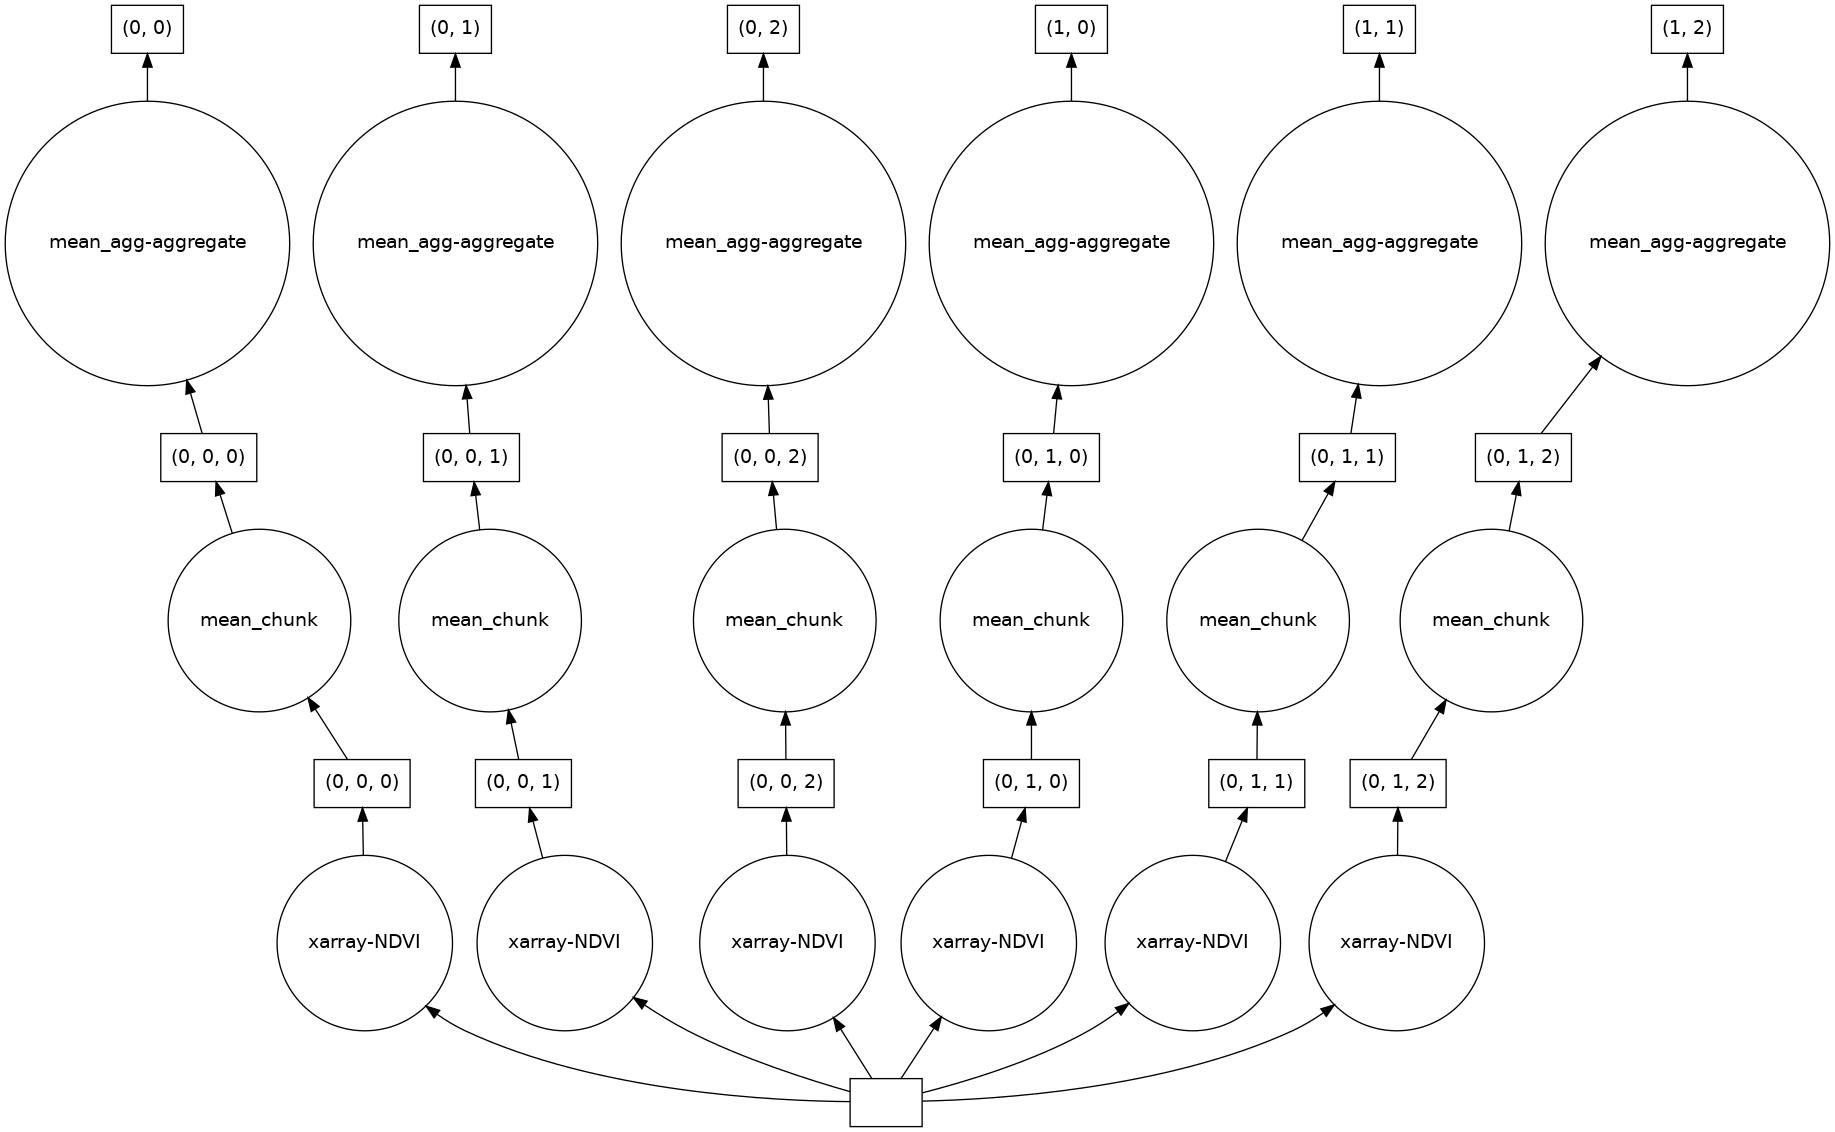

In [20]:
cgls_ds.chunk(chunk).NDVI.mean(dim='time').data.visualize()

In [10]:
cgls_ds.NDVI.mean(dim='time').compute()

<xarray.DataArray 'NDVI' (lat: 1008, lon: 1343)>
array([[117.36842105, 106.68421053,  96.78947368, ..., 129.        ,
        129.        , 129.        ],
       [ 99.10526316,  85.89473684,  82.21052632, ..., 129.        ,
        129.        , 129.        ],
       [ 88.21052632,  81.84210526,  82.42105263, ..., 129.        ,
        129.        , 129.        ],
       ...,
       [177.21052632, 180.47368421, 177.42105263, ..., 172.36842105,
        170.31578947, 167.47368421],
       [179.73684211, 182.        , 180.57894737, ..., 171.84210526,
        170.78947368, 173.47368421],
       [184.89473684, 189.15789474, 187.52631579, ..., 169.47368421,
        174.31578947, 175.78947368]])
Coordinates:
  * lon      (lon) float64 9.001 9.004 9.007 9.01 ... 12.99 12.99 12.99 13.0
  * lat      (lat) float64 45.0 45.0 44.99 44.99 44.99 ... 42.01 42.01 42.0 42.0

In [16]:
tmp=cgls_ds.NDVI.compute().chunk(chunk)
tmp

<xarray.DataArray 'NDVI' (time: 19, lat: 1008, lon: 1343)>
dask.array<xarray-<this-array>, shape=(19, 1008, 1343), dtype=uint8, chunksize=(19, 510, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-01
  * lon      (lon) float64 9.001 9.004 9.007 9.01 ... 12.99 12.99 12.99 13.0
  * lat      (lat) float64 45.0 45.0 44.99 44.99 44.99 ... 42.01 42.01 42.0 42.0
Attributes:
    long_name:     NDVI
    units:         
    grid_mapping:  crs

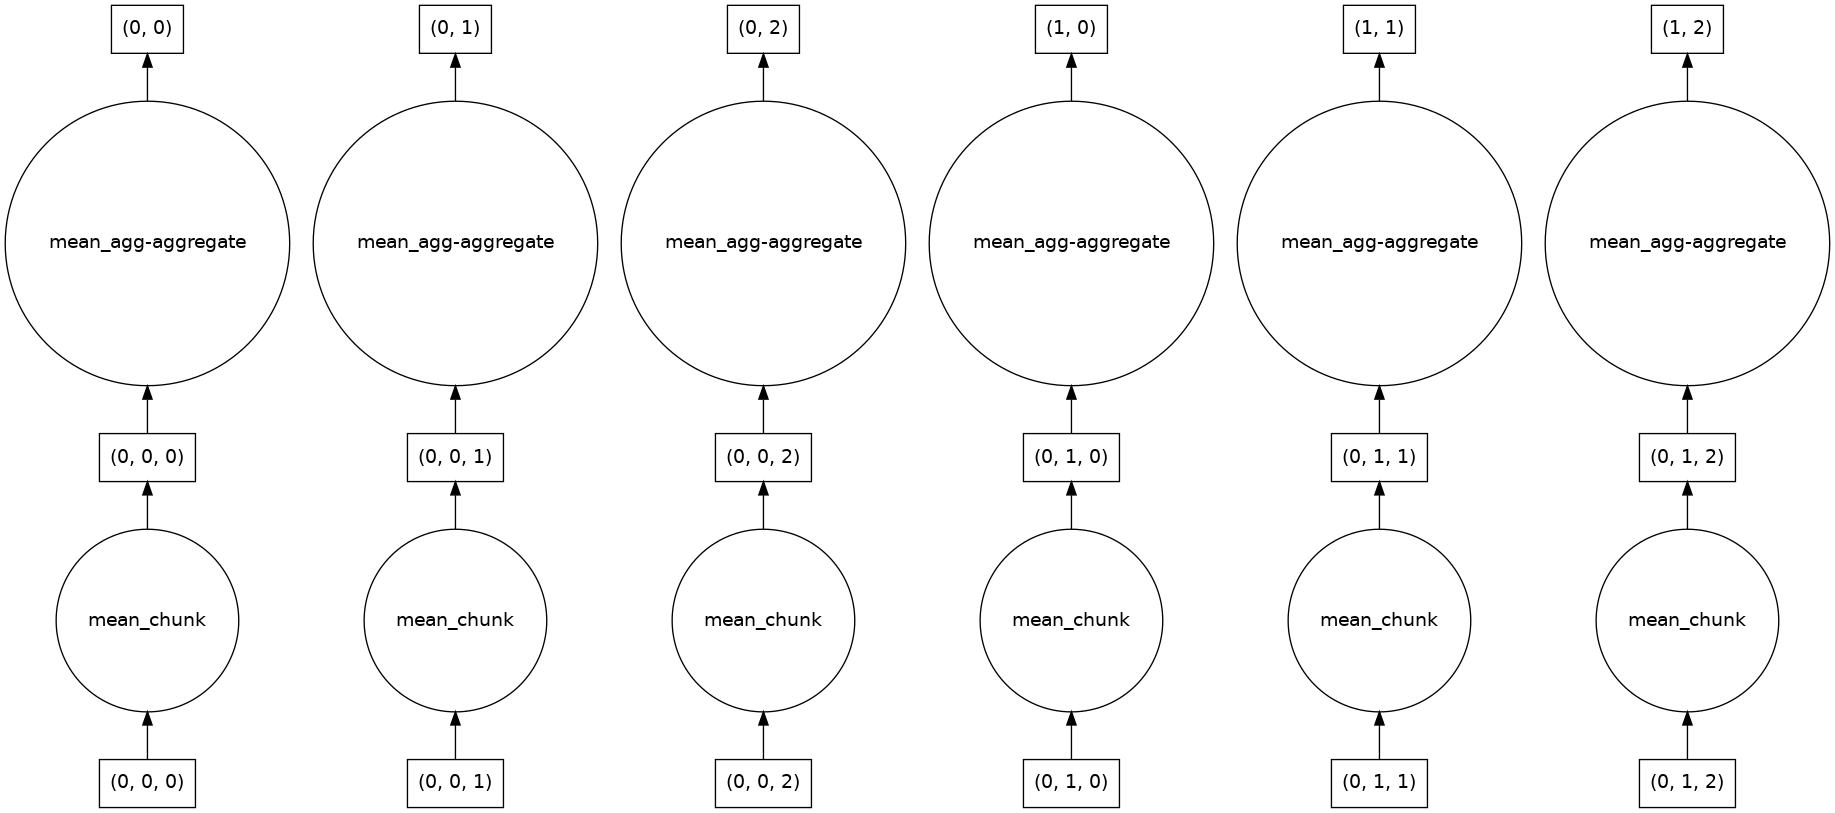

In [18]:
tmp.mean(dim='time').data.visualize()

In [19]:
tmp.mean(dim='time').compute()

<xarray.DataArray 'NDVI' (lat: 1008, lon: 1343)>
array([[117.36842105, 106.68421053,  96.78947368, ..., 129.        ,
        129.        , 129.        ],
       [ 99.10526316,  85.89473684,  82.21052632, ..., 129.        ,
        129.        , 129.        ],
       [ 88.21052632,  81.84210526,  82.42105263, ..., 129.        ,
        129.        , 129.        ],
       ...,
       [177.21052632, 180.47368421, 177.42105263, ..., 172.36842105,
        170.31578947, 167.47368421],
       [179.73684211, 182.        , 180.57894737, ..., 171.84210526,
        170.78947368, 173.47368421],
       [184.89473684, 189.15789474, 187.52631579, ..., 169.47368421,
        174.31578947, 175.78947368]])
Coordinates:
  * lon      (lon) float64 9.001 9.004 9.007 9.01 ... 12.99 12.99 12.99 13.0
  * lat      (lat) float64 45.0 45.0 44.99 44.99 44.99 ... 42.01 42.01 42.0 42.0

In [31]:
cgls_ds.chunk(chunk).to_zarr('test.zarr')


KilledWorker: ('original-xarray-NDVI-10007198de850e37ae762ba790fb5e14', <WorkerState 'tls://10.244.8.9:38043', name: dask-worker-d0c798962f604531bc9622ae7b930983-8znv8, status: closed, memory: 0, processing: 1>)

In [29]:
cgls_ds.to_zarr('test.zarr')

    PID TTY          TIME CMD
   5741 pts/2    00:00:00 ps


In [34]:
!ls -lart test.zarr/NDVI

total 16
-rw-r--r-- 1 jovyan jovyan  368 Jul 27 23:41 .zarray
-rw-r--r-- 1 jovyan jovyan  201 Jul 27 23:41 .zattrs
drwxr-xr-x 2 jovyan jovyan 4096 Jul 27 23:41 .
drwxr-xr-x 7 jovyan jovyan 4096 Jul 27 23:41 ..


In [30]:
!rm -rf test.zarr

# How does dask workers configured?
no common disk space between dask workers and jupyter hub nodes in case of https://pangeo-xxlarge.vm.fedcloud.eu/jupyterhub/
Thus example for creating temporaly zarr file would work only if;
1.  we use local dask and create zarr file in jupyterhub side.
2.  if we use daskgateway, create 'common' disk space from all dask workers which they can write file.  for example s3?


In [77]:

def linuxcmd(x) :
    import subprocess
    cmd=['ls', '/home']
    cmd=['df']
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    o, e = proc.communicate()
    #print(cmd)
    return o.decode('ascii')
test=linuxcmd(1)
print(test)

Filesystem                                                                               1K-blocks     Used Available Use% Mounted on
overlay                                                                                   81120644 12230576  68873684  16% /
tmpfs                                                                                        65536        0     65536   0% /dev
tmpfs                                                                                     16441476        0  16441476   0% /sys/fs/cgroup
kubeserver.localdomain:/pv/daskhub-claim-todaka-pvc-dcb10ce2-a6e1-401f-9aa6-2a4ed454bf95 959852544   399360 910625792   1% /home/jovyan
/dev/sda1                                                                                 81120644 12230576  68873684  16% /etc/hosts
shm                                                                                          65536      316     65220   1% /dev/shm
tmpfs                                                                    

In [76]:

from dask import delayed
#import numpy as np
f=delayed(lambda x: linuxcmd(x))

#client.submit(f(2))
client.compute(f(2))
import dask
dask.compute(f(2))


('Filesystem     1K-blocks     Used Available Use% Mounted on\noverlay         81120644 12294008  68810252  16% /\ntmpfs              65536        0     65536   0% /dev\ntmpfs           16441476        0  16441476   0% /sys/fs/cgroup\ntmpfs            2097152       12   2097140   1% /etc/dask-credentials\n/dev/sda1       81120644 12294008  68810252  16% /etc/hosts\nshm                65536       24     65512   1% /dev/shm\ntmpfs           16441476        0  16441476   0% /proc/acpi\ntmpfs           16441476        0  16441476   0% /proc/scsi\ntmpfs           16441476        0  16441476   0% /sys/firmware\n',)